# Quick Start to Stochastic Network Calculus

In this short tutorial, we show how to obtain delay bounds in the stochastic network calculus (SNC) with moment-generating functions (MGF).
Throughout this tutorial, we assume arrivals and service to be $(\sigma, \rho)$-bounded, as it allows for closed-form solutions of all operators and performance bounds.

# Traffic Classes

Let us dive in immediately into the coding. 
At first, we write down an abstract class "Arrivals".
All traffic classes inherit from it.

In [1]:
from abc import abstractmethod, ABC


class Arrival(ABC):
    """Abstract Arrival class."""

    @abstractmethod
    def sigma(self, theta: float) -> float:
        """
        sigma(theta)
        :param theta: mgf parameter
        """
        pass

    @abstractmethod
    def rho(self, theta: float) -> float:
        """
        rho(theta)
        :param theta: mgf parameter
        """
        pass

We see that both methods take $\theta$ as an argument and return a float.

Similarly, we implement an abstract class for a server.

In [2]:
class Server(ABC):
    """Abstract Server class"""

    @abstractmethod
    def sigma(self, theta: float) -> float:
        """Sigma method"""
        pass

    @abstractmethod
    def rho(self, theta: float) -> float:
        """Rho method"""
        pass

Now, we can already implement traffic classes.
In order to keep it simple, we start with i.i.d. exponentially distributed packet sizes for the arrivals.
This corresponds to the so-called D/M/1-queue, which is the reason why we call this call DM1.
A well-known results yields for this traffic class, we have with $A(s,t)=\sum_{i=s+1}^{t} a_i$ and $0 < \theta < \lambda$
\begin{align*}
\mathrm{E}\left[e^{\theta A(s,t)}\right] &= \left(\frac{\lambda}{\lambda-\theta}\right)^{t-s}\\
&= e^{\log\left(\frac{\lambda}{\lambda-\theta}\right) \cdot (t-s)}\\
&= e^{\theta \frac{1}{\theta}\log\left(\frac{\lambda}{\lambda-\theta}\right) \cdot (t-s)}\\
&= e^{\theta \rho_A(\theta) \cdot (t-s) + \theta \sigma_A(\theta)},
\end{align*}
where
\begin{align*}
\sigma_A(\theta) &= 0,\\
\rho_A(\theta) &= \frac{1}{\theta} \log\left(\frac{\lambda}{\lambda-\theta}\right).
\end{align*}
In our implementation, this yields

In [3]:
class ParameterOutOfBounds(Exception):
    """Exception if input parameter is not feasible in the optimization"""

    def __init__(self, parameter):
        msg = "Parameter is out of bounds, {0}".format(parameter)
        super(ParameterOutOfBounds, self).__init__(msg)
        self.parameter = parameter

In [4]:
from math import log


class DM1(Arrival):
    """Corresponds to D/M/1 queue."""

    def __init__(self, lamb: float, n=1) -> None:
        self.lamb = lamb
        self.n = n
        
    def sigma(self, theta=0.0) -> float:
        """

        :param theta: mgf parameter
        :return:      sigma(theta)
        """
        return 0.0

    def rho(self, theta: float) -> float:
        """
        rho(theta)
        :param theta: mgf parameter
        """
        if theta <= 0:
            raise ParameterOutOfBounds(f"theta = {theta} must be > 0")

        if theta >= self.lamb:
            raise ParameterOutOfBounds(f"theta = {theta} must be < lambda = {self.lamb}")

        return (self.n / theta) * log(self.lamb / (self.lamb - theta))

This class has to inherit from the class Arrival.
Further, we add the parameter $n$ to allow for an aggregate of arrivals.
Also, we check whether $0<\theta<\lambda$, since otherwise, the MGF does not exist.
In order to handle these case (we will see below, that it has pracital advantages), we write our own class for this errors.

For a constant rate server, we proceed in a similar fashion.
We know that for the service process $S(s,t) = c \cdot (t-s)$ with $c \geq 0$, it is $(\sigma_S, \rho_S)$-bounded  with
\begin{align*}
    \sigma(-\theta) =& 0,\\
    \rho(-\theta) =& c.
\end{align*}
Note that in this case, $S(s,t)$ is deterministic.
With respect to the code, this means    

In [5]:
class ConstantRateServer(Server):
    """Constant rate service"""

    def __init__(self, rate: float) -> None:
        self.rate = rate

    def sigma(self, theta=0.0) -> float:
        return 0.0

    def rho(self, theta: float) -> float:
        if theta <= 0:
            raise ParameterOutOfBounds(f"theta = {theta} must be > 0")

        return self.rate

# Single Server Analysis

Now, we can derive for single flow - single server topologies as in 
![1-input-1-output](figures/1-input-1-output.png)
However, this is the most important topology, as we reduce any feed-forward to this network by using the end-to-end service.

Now, we can use this to compute performance bounds.
From SNC theory, we know that, if arrivals and service are $(\sigma, \rho)$-bounded and the stability codition holds, i.e., 
\begin{equation*}
		\rho_A(\theta) < \rho_S(-\theta),
\end{equation*}
then the violation probability of the virtual delay is bounded by
\begin{equation*}
\mathrm{P}(d(t)>T) \leq e^{-\theta \rho_{S}(-\theta)T} \frac{e^{\theta\left(\sigma_{A}(\theta)+\sigma_{S}(-\theta)\right)}}{1-e^{\theta\left(\rho_{A}(\theta)-\rho_{S}(-\theta)\right)}}.
\end{equation*}
Code-wise, this yields

In [6]:
from math import exp

def delay_prob(arr: Arrival,
               ser: Server,
               theta: float,
               T: int) -> float:
    """Implements stationary standard_bound method"""
    if arr.rho(theta) >= ser.rho(theta):
        raise ParameterOutOfBounds("System is not stable")

    return exp(-theta * ser.rho(theta) * T) * exp(theta * (arr.sigma(theta) + ser.sigma(
            theta))) / (1 - exp(theta * (arr.rho(theta) - ser.rho(theta))))

For the D/M/1 arrrival with $\lambda=2.0$ and a constant rate server with rate $1.0$, the probability that the delay is larger than 5 for $\theta=1.0$ is equal to

In [7]:
print(delay_prob(arr=DM1(lamb=2.0), ser=ConstantRateServer(1.0), theta=1.0, T=5))

0.025499237434458494


Of course, since the bound is valid for all $\theta,$ it is desirable to optimize the bound in $\theta$.
A very simple approach is to try many values and take the minimum.

In [8]:
import numpy as np

optimum = np.inf
opt_theta = 0.0
for theta in np.arange(0.1, 5.0, 0.1):
    try:
        candidate = delay_prob(arr=DM1(lamb=2.0), ser=ConstantRateServer(rate=1.0), theta=theta, T=5)
    except ParameterOutOfBounds:
        candidate = np.inf
    
    if candidate < optimum:
        optimum = candidate
        opt_theta = theta
        
print(f"bound on delay violation probability = {optimum}")
print(f"optimal theta = {opt_theta}")

bound on delay violation probability = 0.005122641142859845
optimal theta = 1.4000000000000001


Vice versa, we can also derive a stochastic delay bound for a given violation probability (under stability):
\begin{equation*}
T_\varepsilon =\frac{\sigma_{A}(\theta)+\sigma_{S}(-\theta)}{\rho_{S}(-\theta)} + \frac{1}{\theta \rho_{S}(-\theta)}\log\left(\frac{1}{\varepsilon\left(1-e^{\theta\left(\rho_{A}(\theta)-\rho_{S}(-\theta)\right)}\right)}\right).
\end{equation*}
In Python, this yields

In [9]:
def delay(arr: Arrival,
          ser: Server,
          theta: float,
          epsilon: float) -> float:
    """Implements stationary standard_bound method"""
    if arr.rho(theta) >= ser.rho(theta):
        raise ParameterOutOfBounds("System is not stable")

    log_part = log(1 / (epsilon * (1 - exp(theta * (arr.rho(theta) - ser.rho(theta))))))
    return (arr.sigma(theta) + ser.sigma(theta) + log_part / theta) / ser.rho(theta=theta)

For the traffic classes and parameter from above and violation probability 0.005, we compute

In [10]:
optimum = np.inf
for theta in np.arange(0.1, 5.0, 0.1):
    try:
        candidate = delay(arr=DM1(lamb=2.0), ser=ConstantRateServer(rate=1.0), theta=theta, epsilon=0.005)
    except ParameterOutOfBounds:
        candidate = np.inf
    
    if candidate < optimum:
        optimum = candidate
        
print(f"delay bound = {optimum}")

delay bound = 5.0173087441629844


Of course, we are not limited to D/M/1 systems.
For example, we can use Markov-modulated on-off (MMOO) traffic with transition matrix 
\begin{equation*}
P:=\begin{pmatrix}
	p_{00} & p_{01}\\
	p_{10} & p_{11}
	\end{pmatrix}.
\end{equation*}
In state $0$, no data is sent, whereas in state $1$, traffic with rate $b$ is sent.
This is know to be $(\sigma,\rho)$-bounded with
\begin{align*}
	\sigma_A(\theta) =& 0,\\
	\rho_A(\theta) =& \frac{1}{\theta}\log\left(\frac{p_{00}+p_{11}e^{b \theta}+\sqrt{\left(p_{00}+p_{11}e^{b \theta}\right)^{2}-4\left(p_{00}+p_{11}-1\right)e^{b \theta}}}{2}\right).
\end{align*}

In [11]:
from math import sqrt

class MMOO(Arrival):
    """Discrete Markov Modulated On-Off Traffic"""
    def __init__(self, stay_on: float, stay_off: float, b: float,
                 n=1) -> None:
        self.stay_on = stay_on
        self.stay_off = stay_off
        self.b = b
        self.n = n

    def sigma(self, theta=0.0) -> float:
        return 0.0

    def rho(self, theta: float) -> float:
        if theta <= 0:
            raise ParameterOutOfBounds(f"theta = {theta} must be > 0")

        if self.stay_on <= 0.0 or self.stay_on >= 1.0:
            raise ValueError(f"p_stay_on = {self.stay_on} must be in (0,1)")

        if self.stay_off <= 0.0 or self.stay_off >= 1.0:
            raise ValueError(f"p_stay_off = {self.stay_off} must be in (0,1)")

        off_on = self.stay_off + self.stay_on * exp(theta * self.b)
        sqrt_part = sqrt(off_on**2 - 4 * (self.stay_off + self.stay_on - 1) *
                         exp(theta * self.b))

        rho_mmoo_disc = log(0.5 * (off_on + sqrt_part))

        if rho_mmoo_disc < 0:
            raise ParameterOutOfBounds("rho must be >= 0")

        return rho_mmoo_disc / theta

In [12]:
optimum = np.inf
for theta in np.arange(0.1, 5.0, 0.1):
    try:
        candidate = delay(arr=MMOO(stay_on=0.5, stay_off=0.7, b=2.0), ser=ConstantRateServer(rate=1.0), theta=theta, epsilon=0.005)
    except ParameterOutOfBounds:
        candidate = np.inf
    
    if candidate < optimum:
        optimum = candidate
        
print(f"delay bound = {optimum}")

delay bound = 33.69801819903915


# Network Analysis

In this section, we show how to compute performance for network of the forn
![1-input-2-server](figures/1-input-2-server.png)
Therefore, we need the concatenation theorem:

Assume above topology, where the arrivals of $f_1$ are $A_\mathrm{e2e} = A_1.$
We denote by $D_1 = A_2$ the output of $S_1$, which equals the input at $S_2$, and by $D_\mathrm{e2e} = D_2$ the departures of $S_2.$
Further, we assume the servers to be dynamic $S_1$- and $S_2$-servers, respectively.
Then the end-to-end service, $S_\mathrm{e2e},$ is a dynamic $S_1 \otimes S_2$-server.

Under the additional assumption of independent $\left(\sigma_{S_1}, \rho_{S_1}\right)$ and $\left(\sigma_{S_2}, \rho_{S_2}\right)$-constrained servers, the end-to-end service is $\left(\sigma_{S_\mathrm{e2e}}, \rho_{S_\mathrm{e2e}}\right)$-bounded, where
\begin{align*}
\sigma_{S_\mathrm{e2e}}(-\theta) =& \sigma_{S_{1}}(-\theta)+\sigma_{S_{2}}(-\theta) + \frac{1}{\theta}\log\left(\frac{1}{1-e^{-\theta\left|\rho_{S_{2}}(-\theta)-\rho_{S_{1}}(-\theta)\right|}}\right),\\
\rho_{S_\mathrm{e2e}}(-\theta) =& \min\left\{ \rho_{S_{1}}(-\theta),\rho_{S_2}(-\theta)\right\}
\end{align*}
in case $\rho_{S_{1}}(-\theta) \neq \rho_{S_{2}}(-\theta),$ and
\begin{align*}
\sigma_{S_\mathrm{e2e}}(-\theta) =& \sigma_{S_{1}}(-\theta)+\sigma_{S_{2}}(-\theta),\\
\rho_{S_\mathrm{e2e}}(-\theta) =& \rho_{S_{1}}(-\theta)-\frac{1}{\theta}
\end{align*}
if $\rho_{S_{1}}(-\theta) = \rho_{S_{2}}(-\theta).$

In Python, this can be implemented as follows:

In [13]:
class Convolve(Server):
    """Convolution class."""

    def __init__(self,
                 ser1: Server,
                 ser2: Server) -> None:
        self.ser1 = ser1
        self.ser2 = ser2

    def sigma(self, theta: float) -> float:
        ser_1_sigma = self.ser1.sigma(theta)
        ser_2_sigma = self.ser2.sigma(theta)

        ser_1_rho = self.ser1.rho(theta)
        ser_2_rho = self.ser2.rho(theta)

        if ser_1_rho!= ser_2_rho:
            return ser_1_sigma + ser_2_sigma -log(1 - exp(-theta * abs(ser_1_rho - ser_2_rho))) / theta

        else:
            return ser_1_sigma + ser_2_sigma

    def rho(self, theta: float) -> float:
        ser_1_rho = self.ser1.rho(theta)
        ser_2_rho = self.ser2.rho(theta)

        if ser_1_rho < 0 or ser_2_rho < 0:
            raise ParameterOutOfBounds("The rhos must be > 0")

        if ser_1_rho!= ser_2_rho:
            return min(ser_1_rho, ser_2_rho)

        else:
            return ser_1_rho_p - 1 / theta

Observe that the convolution of two service processes is, again, a service process.
Hence, the class Convolve() inherits from the class Server().
Consider again D/M/1 arrival with $\lambda=2.0$ and server rates $c_1=2.0$, $c_2=1.5$.
The we compute

In [14]:
convolved_servers = Convolve(ser1=ConstantRateServer(rate=2.0), ser2=ConstantRateServer(rate=1.5))

optimum = np.inf
for theta in np.arange(0.1, 5.0, 0.1):
    try:
        candidate = delay(arr=DM1(lamb=2.0), ser=convolved_servers, theta=theta, epsilon=0.005)
    except ParameterOutOfBounds:
        candidate = np.inf
    
    if candidate < optimum:
        optimum = candidate
        
print(f"optimal bound on delay violation probability = {optimum}")

optimal bound on delay violation probability = 2.5685416909311694


# Leftover Service
![2-input-1-server](figures/2-input-1-server.png)

In this section, we want to compute the leftover service for the flow of interest.
The code is based on the following theorem.

Consider two flows, $f_1$ and $f_2,$ with respective arrival processes $A_1(s,t)$ and $A_2(s,t)$, that receive service process $S(s, t)$.
Further, we assume $f_1$ to be our foi and the scheduling to be *arbitrary multiplexing*.
If the server is work-conserving, then the foi sees the dynamic $S$-server
\begin{equation}
S_{\mathrm{l.o.}}^{\mathrm{ARB}}(s,t) = S_{\mathrm{l.o.}}(s,t) = \left[S(s,t) - A_2(s,t)\right]^+, \quad 0 \leq s \leq t
\end{equation}
the so-called leftover service.
This is also denoted by $S_{\mathrm{l.o.}} = S \ominus A_2.$

Let $\theta >0.$
If we further assume the arrival process $A_2$ and the service process to be independent, $\left(\sigma_{A_2}, \rho_{A_2}\right)$ and $\left(\sigma_S, \rho_S\right)$-bounded, respectively, then the leftover service is $\left(\sigma_{S_{\mathrm{l.o.}}}, \rho_{S_{\mathrm{l.o.}}}\right)$-bounded with
\begin{align*}
\sigma_{S_{\mathrm{l.o.}}}(-\theta) =& \sigma_{S}(-\theta) + \sigma_{A_2}(\theta),\\
\rho_{S_{\mathrm{l.o.}}}(-\theta) =& \rho_{S}(-\theta) - \rho_{A_2}(\theta).
\end{align*}

In [15]:
class Leftover(Server):
    """Class to compute the leftover service."""
    def __init__(self, ser: Server, arr: Arrival) -> None:
        self.arr = arr
        self.ser = ser

    def sigma(self, theta):
        return self.ser.sigma(theta) + self.arr.sigma(theta)

    def rho(self, theta):
        if self.ser.rho(theta) < 0 or self.arr.rho(theta) < 0:
            raise ParameterOutOfBounds("The rhos must be >= 0")

        return self.ser.rho(theta) - self.arr.rho(theta)

In [16]:
leftover_service = Leftover(ser=ConstantRateServer(rate=3.0), arr=MMOO(stay_on=0.5, stay_off=0.7, b=3.0))

optimum = np.inf
for theta in np.arange(0.1, 5.0, 0.1):
    try:
        candidate = delay(arr=DM1(lamb=2.0), ser=leftover_service, theta=theta, epsilon=0.005)
    except ParameterOutOfBounds:
        candidate = np.inf
    
    if candidate < optimum:
        optimum = candidate
        
print(f"optimal bound on delay violation probability = {optimum}")

optimal bound on delay violation probability = 11.501281262813745


# Analysis of Dependent Processes

So far, we have only talked about the independent case.
At last, we also would like to show how to proceed, if we apply Hölder's inequality.
For example, let us consider two multiplexed arrival processes that are not assumed to be independet.

Let $A_1$ and $A_2$ be $(\sigma_{A_1}, \rho_{A_1})$-bounded and $(\sigma_{A_2}, \rho_{A_2})$-bounded arrival processes, respectively.
	Then the sum is $(\sigma_{A_1 + A_2}, \rho_{A_1 + A_2})$-bounded with
	\begin{align*}
	\sigma_{A_1 + A_2}(\theta) =& \sigma_{A_1}(p\theta) + \sigma_{A_2}(q\theta),\\
	\rho_{A_1 + A_2}(\theta) =& \rho_{A_1}(p\theta) + \rho_{A_2}(q\theta),
	\end{align*}
	 where $p,q >1$ such that $\frac{1}{p} + \frac{1}{q} =1.$

In [17]:
class AggregateGeneral(Arrival):
    """Multiple (list) aggregation class."""
    def __init__(self,
                 arr1: Arrival,
                 arr2: Arrival,
                 p: float) -> None:
        self.arr1 = arr1
        self.arr2 = arr2
        self.p = p
        self.q = p / (p - 1.0)

    def sigma(self, theta: float) -> float:
        return self.arr1.sigma(self.p * theta) + self.arr2.sigma(self.q * theta)

    def rho(self, theta: float) -> float:
        if self.arr1.rho(self.p * theta) < 0 or self.arr2.rho(self.q * theta) < 0:
            raise ParameterOutOfBounds("The rhos must be >= 0")

        return self.arr1.rho(self.p * theta) + self.arr2.rho(self.q * theta)

In [18]:
optimum = np.inf
opt_theta = 0.0
opt_p = 0.0
for theta in np.arange(0.1, 5.0, 0.1):
    for p in np.arange(1.1, 5.0, 0.1):
        try:
            aggregate_dependent = AggregateGeneral(arr1=MMOO(stay_on=0.5, stay_off=0.7, b=2.0), arr2=DM1(lamb=2.0), p=p)
            candidate = delay(arr=aggregate_dependent, ser=ConstantRateServer(rate=2.0), theta=theta, epsilon=0.005)
        except ParameterOutOfBounds:
            candidate = np.inf
        
        if candidate < optimum:
            optimum = candidate
            opt_theta = theta
            opt_p = p
        
print(f"delay bound = {optimum}")
print(f"optimal theta = {opt_theta}")
print(f"optimal p {opt_p}")

delay bound = 10.890508299559576
optimal theta = 0.4
optimal p 1.7000000000000006


# Delay Plot

Let us visualize the obtainable delay bounds with the help of the Python library "matplotlib".

Text(0, 0.5, 'Violation Probability')

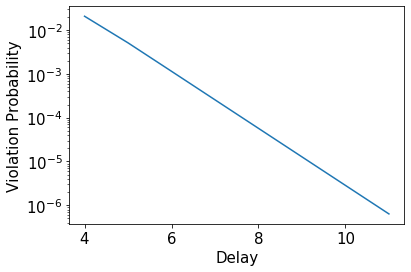

In [19]:
import matplotlib.pyplot as plt

def delay_prob_opt(T: int):
    optimum = np.inf
    for theta in np.arange(0.1, 5.0, 0.1):
        try:
            candidate = delay_prob(arr=DM1(lamb=2.0), ser=ConstantRateServer(rate=1.0), theta=theta, T=T)
        except ParameterOutOfBounds:
            candidate = np.inf

        if candidate < optimum:
            optimum = candidate
            
    return optimum


x_values = range(4, 12)
y_values = [delay_prob_opt(T) for T in x_values]
        
plt.plot(x_values, y_values)
plt.yscale("log")
plt.tick_params(labelsize=15)
plt.xlabel("Delay", fontsize=15)
plt.ylabel("Violation Probability", fontsize=15)